In [1]:
# IMPORTS
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
# DATASET
df = pd.read_csv("./healthcare-dataset-stroke-data_train.csv")
df.drop(["id", "Unnamed: 0"], axis=1, inplace=True)

### BMI por edad (medianas)
* Hasta:  10 años - BMI: 18.30  
* Hasta:  20 años - BMI: 23.80  
* Hasta:  30 años - BMI: 26.70  
* Hasta:  40 años - BMI: 29.70  
* Hasta:  50 años - BMI: 30.00  
* Hasta:  60 años - BMI: 30.90  
* Hasta:  70 años - BMI: 30.00  
* Mayor 70 años - BMI: 28.30  
* Mayor 30 años - BMI: 29.80  

Hago grupos hasta 10, hasta 20, hasta 30 y mayor a 30 para rellenar NaNs.

In [4]:
bmi_fill = {
    "hasta_10": 18.3,
    "hasta_20": 23.8,
    "hasta_30": 26.7,
    "mayor_30": 29.8,
}

In [5]:
# LLENO NaNs SEGUN EDAD
df.bmi.fillna(0, inplace=True)
for i in range(len(df)):
    if df.bmi.iloc[i] == 0:
        if (df.age.iloc[i]<=10):
            df.bmi.iloc[i] = bmi_fill["hasta_10"]
        elif (df.age.loc[i]<=20)&(df.age.loc[i]>10):
            df.bmi.iloc[i] = bmi_fill["hasta_20"]
        elif (df.age.loc[i]<=30)&(df.age.loc[i]>20):
            df.bmi.iloc[i] = bmi_fill["hasta_30"]
        else:
            df.bmi.iloc[i] = bmi_fill["mayor_30"]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


## ENCODING

In [6]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder

## La idea ahora sería hacerle OHE a work_type y smoking_status; y label encoding a gender y Residence_type, y después probar de nuevo los modelos.  
Quizás habría que usar el ColumnTransformer?

In [7]:
ohe_cols = ["work_type", "smoking_status"]
label_cols = ["gender", "ever_married", "Residence_type"]
cat_cols = ohe_cols+label_cols
num_cols = ["avg_glucose_level", "bmi"]

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

class ModifiedLabelEncoder(LabelEncoder):

    def fit_transform(self, y, *args, **kwargs):
        return super().fit_transform(y).reshape(-1, 1)

    def transform(self, y, *args, **kwargs):
        return super().transform(y).reshape(-1, 1)

# num_pipeline = Pipeline(["std_scaler", StandardScaler()])

# label_pipeline = Pipeline(["label_enc", LabelEncoder()])

# ohe_pipeline = Pipeline(["ohe", OneHotEncoder()])

full_pipeline = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("ohe", OneHotEncoder(), ohe_cols),
    ("label_1", ModifiedLabelEncoder(), label_cols[0]),
    ("label_2", ModifiedLabelEncoder(), label_cols[1]),
    ("label_3", ModifiedLabelEncoder(), label_cols[2]),
])

In [9]:
df_prepared = full_pipeline.fit_transform(df)

In [10]:
df_processed = pd.DataFrame(df_prepared)
# df_processed.columns = num_cols + ohe_cols + label_cols

In [11]:
df_processed[0].to_numpy().std()

1.0

In [12]:
df_listo = pd.concat([df_processed, df[["hypertension", "heart_disease"]]], axis=1)

In [13]:
df_listo

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,hypertension,heart_disease
0,-0.896710,-0.390718,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0,0
1,-1.039486,0.074254,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0,0
2,-0.886402,-0.933185,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0,0
3,-0.742529,-0.067821,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,0
4,-0.509613,0.100085,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4083,-0.143132,-1.372325,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0,0
4084,0.958504,-0.468213,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0,0
4085,-0.086109,0.048422,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0,0
4086,-0.129973,2.747841,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0,0


## MODELOS

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score

lr = LogisticRegression()
lr.fit(df_listo, df.stroke)
ypred = cross_val_predict(lr, df_listo, df.stroke)
y_score_log = cross_val_predict(lr, df_listo, df.stroke, method="predict_proba")
confusion_matrix(df.stroke, ypred)

array([[3884,    0],
       [ 204,    0]])

In [ ]:
print(accuracy_score(df.stroke, ypred))
print(recall_score(df.stroke, ypred))

0.9500978473581213
0.0


In [ ]:
# Con pesos
pesos = {0:1, 1:10}
lr = LogisticRegression(class_weight="balanced")
lr.fit(df_listo, df.stroke)
ypred = cross_val_predict(lr, df_listo, df.stroke)
y_score_log = cross_val_predict(lr, df_listo, df.stroke, method="predict_proba")
confusion_matrix(df.stroke, ypred)

array([[2715, 1169],
       [  67,  137]])

In [ ]:
from sklearn.metrics import recall_score, roc_auc_score

print(accuracy_score(df.stroke, ypred))
print(recall_score(df.stroke, ypred))
print(roc_auc_score(df.stroke, ypred))

0.6976516634050881
0.6715686274509803
0.6852951273197229


In [ ]:
df_listo

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,hypertension,heart_disease
0,-0.896710,-0.390718,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0,0
1,-1.039486,0.074254,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0,0
2,-0.886402,-0.933185,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0,0
3,-0.742529,-0.067821,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,0
4,-0.509613,0.100085,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4083,-0.143132,-1.372325,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0,0
4084,0.958504,-0.468213,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0,0
4085,-0.086109,0.048422,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0,0
4086,-0.129973,2.747841,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0,0


# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
peso_clases = {0:1, 1:19}
reg_rf = RandomForestClassifier(random_state=42, class_weight="balanced")
param_grid = {"n_estimators":np.arange(10,100, 10),
              "max_depth":np.arange(4, 100, 10),
              "min_samples_leaf":np.arange(1,30, 5)
             }
reg_rf.fit(df_listo, df.stroke)
#gsrf = GridSearchCV(reg_rf, param_grid, verbose=3)
rsrf = RandomizedSearchCV(reg_rf, param_grid, verbose=3, n_iter=25, random_state=42)
rsrf.fit(df_listo, df.stroke)
#ypred_gsrf = cross_val_predict(gsrf.best_estimator_, _train_scaled, t_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] n_estimators=50, min_samples_leaf=6, max_depth=44 ...............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=50, min_samples_leaf=6, max_depth=44, score=0.910, total=   0.3s
[CV] n_estimators=50, min_samples_leaf=6, max_depth=44 ...............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  n_estimators=50, min_samples_leaf=6, max_depth=44, score=0.914, total=   0.3s
[CV] n_estimators=50, min_samples_leaf=6, max_depth=44 ...............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


[CV]  n_estimators=50, min_samples_leaf=6, max_depth=44, score=0.902, total=   0.3s
[CV] n_estimators=50, min_samples_leaf=6, max_depth=44 ...............
[CV]  n_estimators=50, min_samples_leaf=6, max_depth=44, score=0.897, total=   0.3s
[CV] n_estimators=50, min_samples_leaf=6, max_depth=44 ...............
[CV]  n_estimators=50, min_samples_leaf=6, max_depth=44, score=0.896, total=   0.3s
[CV] n_estimators=20, min_samples_leaf=11, max_depth=14 ..............
[CV]  n_estimators=20, min_samples_leaf=11, max_depth=14, score=0.864, total=   0.1s
[CV] n_estimators=20, min_samples_leaf=11, max_depth=14 ..............
[CV]  n_estimators=20, min_samples_leaf=11, max_depth=14, score=0.848, total=   0.1s
[CV] n_estimators=20, min_samples_leaf=11, max_depth=14 ..............
[CV]  n_estimators=20, min_samples_leaf=11, max_depth=14, score=0.861, total=   0.1s
[CV] n_estimators=20, min_samples_leaf=11, max_depth=14 ..............
[CV]  n_estimators=20, min_samples_leaf=11, max_depth=14, score=0.8

[CV]  n_estimators=10, min_samples_leaf=6, max_depth=24, score=0.886, total=   0.1s
[CV] n_estimators=10, min_samples_leaf=6, max_depth=24 ...............
[CV]  n_estimators=10, min_samples_leaf=6, max_depth=24, score=0.878, total=   0.1s
[CV] n_estimators=10, min_samples_leaf=6, max_depth=24 ...............
[CV]  n_estimators=10, min_samples_leaf=6, max_depth=24, score=0.891, total=   0.1s
[CV] n_estimators=60, min_samples_leaf=16, max_depth=74 ..............
[CV]  n_estimators=60, min_samples_leaf=16, max_depth=74, score=0.847, total=   0.4s
[CV] n_estimators=60, min_samples_leaf=16, max_depth=74 ..............
[CV]  n_estimators=60, min_samples_leaf=16, max_depth=74, score=0.837, total=   0.3s
[CV] n_estimators=60, min_samples_leaf=16, max_depth=74 ..............
[CV]  n_estimators=60, min_samples_leaf=16, max_depth=74, score=0.834, total=   0.3s
[CV] n_estimators=60, min_samples_leaf=16, max_depth=74 ..............
[CV]  n_estimators=60, min_samples_leaf=16, max_depth=74, score=0.8

[CV]  n_estimators=20, min_samples_leaf=16, max_depth=54, score=0.812, total=   0.1s
[CV] n_estimators=20, min_samples_leaf=16, max_depth=54 ..............
[CV]  n_estimators=20, min_samples_leaf=16, max_depth=54, score=0.839, total=   0.1s
[CV] n_estimators=20, min_samples_leaf=16, max_depth=54 ..............
[CV]  n_estimators=20, min_samples_leaf=16, max_depth=54, score=0.815, total=   0.1s
[CV] n_estimators=20, min_samples_leaf=16, max_depth=54 ..............
[CV]  n_estimators=20, min_samples_leaf=16, max_depth=54, score=0.823, total=   0.1s
[CV] n_estimators=60, min_samples_leaf=1, max_depth=34 ...............
[CV]  n_estimators=60, min_samples_leaf=1, max_depth=34, score=0.950, total=   0.4s
[CV] n_estimators=60, min_samples_leaf=1, max_depth=34 ...............
[CV]  n_estimators=60, min_samples_leaf=1, max_depth=34, score=0.946, total=   0.4s
[CV] n_estimators=60, min_samples_leaf=1, max_depth=34 ...............
[CV]  n_estimators=60, min_samples_leaf=1, max_depth=34, score=0.9

[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:   32.3s finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight='balanced',
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
      

In [ ]:
rsrf.best_params_

{'n_estimators': 60, 'min_samples_leaf': 1, 'max_depth': 74}

In [ ]:
ypred_rsrf = cross_val_predict(rsrf.best_estimator_, df_listo, df.stroke)
confusion_matrix(df.stroke, ypred_rsrf)

array([[3873,   11],
       [ 203,    1]])

In [ ]:
print(accuracy_score(df.stroke, ypred_rsrf))
print(recall_score(df.stroke, ypred_rsrf))

0.9476516634050881
0.004901960784313725


## Usando scoring = F1 para el randomized search

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
peso_clases = {0:1, 1:19}
reg_rf = RandomForestClassifier(random_state=42, class_weight="balanced")
param_grid = {"n_estimators":np.arange(100,500, 10),
              "max_depth":np.arange(200, 500, 10),
              "min_samples_leaf":np.arange(1,30, 5)
             }
reg_rf.fit(df_listo, df.stroke)
#gsrf = GridSearchCV(reg_rf, param_grid, verbose=3)
rsrf = RandomizedSearchCV(reg_rf, param_grid, verbose=3, n_iter=25, random_state=42, scoring="f1")
rsrf.fit(df_listo, df.stroke)
#ypred_gsrf = cross_val_predict(gsrf.best_estimator_, _train_scaled, t_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] n_estimators=300, min_samples_leaf=16, max_depth=230 ............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=300, min_samples_leaf=16, max_depth=230, score=0.211, total=   1.8s
[CV] n_estimators=300, min_samples_leaf=16, max_depth=230 ............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV]  n_estimators=300, min_samples_leaf=16, max_depth=230, score=0.229, total=   1.8s
[CV] n_estimators=300, min_samples_leaf=16, max_depth=230 ............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.6s remaining:    0.0s


KeyboardInterrupt: 

In [ ]:
rsrf.best_params_

{'n_estimators': 150, 'min_samples_leaf': 11, 'max_depth': 384}

In [ ]:
ypred_rsrf = cross_val_predict(rsrf.best_estimator_, df_listo, df.stroke)
confusion_matrix(df.stroke, ypred_rsrf)

array([[3473,  411],
       [ 131,   73]])

In [ ]:
print(accuracy_score(df.stroke, ypred_rsrf))
print(recall_score(df.stroke, ypred_rsrf))

0.8674168297455969
0.35784313725490197


## Usando AUC_roc como scoring

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
peso_clases = {0:1, 1:19}
reg_rf = RandomForestClassifier(random_state=42, class_weight="balanced")
param_grid = {"n_estimators":np.arange(100,500, 10),
              "max_depth":np.arange(200, 500, 10),
              "min_samples_leaf":np.arange(1,600, 5)
             }
reg_rf.fit(df_listo, df.stroke)
#gsrf = GridSearchCV(reg_rf, param_grid, verbose=3)
rsrf = RandomizedSearchCV(reg_rf, param_grid, verbose=3, n_iter=35, random_state=42, scoring="roc_auc")
rsrf.fit(df_listo, df.stroke)
#ypred_gsrf = cross_val_predict(gsrf.best_estimator_, _train_scaled, t_train)

Fitting 5 folds for each of 35 candidates, totalling 175 fits
[CV] n_estimators=480, min_samples_leaf=241, max_depth=450 ...........


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=480, min_samples_leaf=241, max_depth=450, score=0.731, total=   1.9s
[CV] n_estimators=480, min_samples_leaf=241, max_depth=450 ...........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s


[CV]  n_estimators=480, min_samples_leaf=241, max_depth=450, score=0.755, total=   1.9s
[CV] n_estimators=480, min_samples_leaf=241, max_depth=450 ...........


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.8s remaining:    0.0s


[CV]  n_estimators=480, min_samples_leaf=241, max_depth=450, score=0.683, total=   1.9s
[CV] n_estimators=480, min_samples_leaf=241, max_depth=450 ...........
[CV]  n_estimators=480, min_samples_leaf=241, max_depth=450, score=0.707, total=   1.9s
[CV] n_estimators=480, min_samples_leaf=241, max_depth=450 ...........
[CV]  n_estimators=480, min_samples_leaf=241, max_depth=450, score=0.728, total=   1.9s
[CV] n_estimators=220, min_samples_leaf=291, max_depth=470 ...........
[CV]  n_estimators=220, min_samples_leaf=291, max_depth=470, score=0.726, total=   0.8s
[CV] n_estimators=220, min_samples_leaf=291, max_depth=470 ...........
[CV]  n_estimators=220, min_samples_leaf=291, max_depth=470, score=0.749, total=   0.8s
[CV] n_estimators=220, min_samples_leaf=291, max_depth=470 ...........
[CV]  n_estimators=220, min_samples_leaf=291, max_depth=470, score=0.684, total=   0.8s
[CV] n_estimators=220, min_samples_leaf=291, max_depth=470 ...........
[CV]  n_estimators=220, min_samples_leaf=291, 

[CV]  n_estimators=330, min_samples_leaf=201, max_depth=230, score=0.740, total=   1.3s
[CV] n_estimators=200, min_samples_leaf=336, max_depth=280 ...........
[CV]  n_estimators=200, min_samples_leaf=336, max_depth=280, score=0.717, total=   0.7s
[CV] n_estimators=200, min_samples_leaf=336, max_depth=280 ...........
[CV]  n_estimators=200, min_samples_leaf=336, max_depth=280, score=0.739, total=   0.7s
[CV] n_estimators=200, min_samples_leaf=336, max_depth=280 ...........
[CV]  n_estimators=200, min_samples_leaf=336, max_depth=280, score=0.674, total=   0.7s
[CV] n_estimators=200, min_samples_leaf=336, max_depth=280 ...........
[CV]  n_estimators=200, min_samples_leaf=336, max_depth=280, score=0.694, total=   0.7s
[CV] n_estimators=200, min_samples_leaf=336, max_depth=280 ...........
[CV]  n_estimators=200, min_samples_leaf=336, max_depth=280, score=0.710, total=   0.7s
[CV] n_estimators=310, min_samples_leaf=1, max_depth=340 .............
[CV]  n_estimators=310, min_samples_leaf=1, ma

[CV]  n_estimators=480, min_samples_leaf=356, max_depth=370, score=0.737, total=   1.7s
[CV] n_estimators=480, min_samples_leaf=356, max_depth=370 ...........
[CV]  n_estimators=480, min_samples_leaf=356, max_depth=370, score=0.674, total=   1.7s
[CV] n_estimators=480, min_samples_leaf=356, max_depth=370 ...........
[CV]  n_estimators=480, min_samples_leaf=356, max_depth=370, score=0.694, total=   1.7s
[CV] n_estimators=480, min_samples_leaf=356, max_depth=370 ...........
[CV]  n_estimators=480, min_samples_leaf=356, max_depth=370, score=0.712, total=   1.7s
[CV] n_estimators=270, min_samples_leaf=316, max_depth=450 ...........
[CV]  n_estimators=270, min_samples_leaf=316, max_depth=450, score=0.721, total=   1.0s
[CV] n_estimators=270, min_samples_leaf=316, max_depth=450 ...........
[CV]  n_estimators=270, min_samples_leaf=316, max_depth=450, score=0.742, total=   1.0s
[CV] n_estimators=270, min_samples_leaf=316, max_depth=450 ...........
[CV]  n_estimators=270, min_samples_leaf=316, 

[CV]  n_estimators=160, min_samples_leaf=511, max_depth=310, score=0.679, total=   0.6s
[CV] n_estimators=160, min_samples_leaf=511, max_depth=310 ...........
[CV]  n_estimators=160, min_samples_leaf=511, max_depth=310, score=0.690, total=   0.6s
[CV] n_estimators=130, min_samples_leaf=551, max_depth=330 ...........
[CV]  n_estimators=130, min_samples_leaf=551, max_depth=330, score=0.704, total=   0.5s
[CV] n_estimators=130, min_samples_leaf=551, max_depth=330 ...........
[CV]  n_estimators=130, min_samples_leaf=551, max_depth=330, score=0.718, total=   0.5s
[CV] n_estimators=130, min_samples_leaf=551, max_depth=330 ...........
[CV]  n_estimators=130, min_samples_leaf=551, max_depth=330, score=0.681, total=   0.5s
[CV] n_estimators=130, min_samples_leaf=551, max_depth=330 ...........
[CV]  n_estimators=130, min_samples_leaf=551, max_depth=330, score=0.676, total=   0.5s
[CV] n_estimators=130, min_samples_leaf=551, max_depth=330 ...........
[CV]  n_estimators=130, min_samples_leaf=551, 

[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:  3.2min finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight='balanced',
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
      

In [ ]:
rsrf.best_params_

{'n_estimators': 410, 'min_samples_leaf': 61, 'max_depth': 210}

In [ ]:
ypred_rsrf = cross_val_predict(rsrf.best_estimator_, df_listo, df.stroke)
confusion_matrix(df.stroke, ypred_rsrf)

array([[2940,  944],
       [  81,  123]])

In [ ]:
print(accuracy_score(df.stroke, ypred_rsrf))
print(recall_score(df.stroke, ypred_rsrf))

0.74926614481409
0.6029411764705882


In [ ]:
print(roc_auc_score(df.stroke, ypred_rsrf))

0.6799463863815352


# Boosting


## AdaBoost


In [53]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

dt_stump = DecisionTreeClassifier(max_depth=1, min_samples_leaf=1)

ada_clf = AdaBoostClassifier(dt_stump, algorithm="SAMME.R", random_state=42)
ada_clf.fit(df_listo, df.stroke)
param_grid = {"n_estimators":np.arange(10,300, 10),
              "learning_rate": np.linspace(0.1, 1.5, 40)
             }

rs_ada = RandomizedSearchCV(ada_clf, param_grid, verbose=3, n_iter=35, random_state=42, scoring="f1")
rs_ada.fit(df_listo, df.stroke)

Fitting 5 folds for each of 35 candidates, totalling 175 fits
[CV] n_estimators=120, learning_rate=0.9615384615384615 ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=120, learning_rate=0.9615384615384615, score=0.000, total=   0.5s
[CV] n_estimators=120, learning_rate=0.9615384615384615 ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  n_estimators=120, learning_rate=0.9615384615384615, score=0.000, total=   0.5s
[CV] n_estimators=120, learning_rate=0.9615384615384615 ..............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s


[CV]  n_estimators=120, learning_rate=0.9615384615384615, score=0.000, total=   0.5s
[CV] n_estimators=120, learning_rate=0.9615384615384615 ..............
[CV]  n_estimators=120, learning_rate=0.9615384615384615, score=0.042, total=   0.5s
[CV] n_estimators=120, learning_rate=0.9615384615384615 ..............
[CV]  n_estimators=120, learning_rate=0.9615384615384615, score=0.000, total=   0.4s
[CV] n_estimators=210, learning_rate=1.5 .............................
[CV] . n_estimators=210, learning_rate=1.5, score=0.000, total=   0.8s
[CV] n_estimators=210, learning_rate=1.5 .............................
[CV] . n_estimators=210, learning_rate=1.5, score=0.000, total=   0.8s
[CV] n_estimators=210, learning_rate=1.5 .............................
[CV] . n_estimators=210, learning_rate=1.5, score=0.000, total=   0.8s
[CV] n_estimators=210, learning_rate=1.5 .............................
[CV] . n_estimators=210, learning_rate=1.5, score=0.083, total=   0.8s
[CV] n_estimators=210, learning_rat

[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:  1.9min finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                                base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                                      class_weight=None,
                                                                                      criterion='gini',
                                                                                      max_depth=1,
                                                                                      max_features=None,
                                                                                      max_leaf_nodes=None,
                                                                                      min_impurity_decrease=0.0,
                                                                                      min_impurity_split=None,
                                         

In [54]:
rs_ada.best_params_

{'learning_rate': 1.141025641025641, 'n_estimators': 20}

In [55]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
ypred_rs_ada = cross_val_predict(rs_ada.best_estimator_, df_listo, df.stroke)
confusion_matrix(df.stroke, ypred_rs_ada)

array([[3872,   12],
       [ 202,    2]])

In [56]:
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score
print(accuracy_score(df.stroke, ypred_rs_ada))
print(recall_score(df.stroke, ypred_rs_ada))
print(roc_auc_score(df.stroke, ypred_rs_ada))

0.9476516634050881
0.00980392156862745
0.5033571616082065


## GradientBoost

# Red Neuronal Artificial, ANN

In [14]:
from tensorflow import keras
import tensorflow as tf

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_val, t_train, t_val = train_test_split(df_listo, df.stroke, test_size=0.15)

In [16]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [17]:
#Definimos una capa especial, que es la entrada del modelo:
input_ = keras.layers.Input(shape=[df_listo.shape[1]])
#Luego se instancia cada capa y se aplica como una función a la salida de la capa anterior

hidden1 = keras.layers.Dense(40, activation="relu")(input_)
drop1 = keras.layers.Dropout(0.2)(hidden1)
hidden2 = keras.layers.Dense(20, activation="relu")(drop1)
drop2 = keras.layers.Dropout(0.2)(hidden2)
hidden3 = keras.layers.Dense(10, activation="relu")(drop2)
drop3 = keras.layers.Dropout(0.2)(hidden3)
output = keras.layers.Dense(1, activation="sigmoid")(drop3)

#Cuando se haya llegado a las las salidas, podemos definir el modelo:
model = keras.models.Model(inputs=[input_], outputs=[output])

In [18]:
early = keras.callbacks.EarlyStopping(patience=17, restore_best_weights=True)
model.compile(loss="binary_crossentropy",
              optimizer="sgd",
              metrics=["accuracy",])

In [ ]:
#Cuantas capas hay?
model.layers

In [ ]:
#cómo es el modelo?
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 16)]              0         
_________________________________________________________________
dense (Dense)                (None, 40)                680       
_________________________________________________________________
dropout (Dropout)            (None, 40)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                820       
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                210       
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)                0     

In [ ]:
pesos = {0:1.0, 1:25}
history = model.fit(epochs=100, batch_size=32, x=X_train, y= t_train, validation_data=(X_val, t_val), 
                    callbacks=[early,], class_weight=pesos)

Epoch 1/100
109/109 [==============================] - 1s 4ms/step - loss: 1.5144 - accuracy: 0.2355 - val_loss: 0.7921 - val_accuracy: 0.0570
Epoch 2/100
109/109 [==============================] - 0s 2ms/step - loss: 1.4982 - accuracy: 0.1163 - val_loss: 0.7984 - val_accuracy: 0.0619
Epoch 3/100
109/109 [==============================] - 0s 2ms/step - loss: 1.4659 - accuracy: 0.1298 - val_loss: 0.7863 - val_accuracy: 0.1254
Epoch 4/100
109/109 [==============================] - 0s 2ms/step - loss: 1.4311 - accuracy: 0.1851 - val_loss: 0.8043 - val_accuracy: 0.1922
Epoch 5/100
109/109 [==============================] - 0s 2ms/step - loss: 1.4401 - accuracy: 0.3054 - val_loss: 0.8347 - val_accuracy: 0.2068
Epoch 6/100
109/109 [==============================] - 0s 2ms/step - loss: 1.4183 - accuracy: 0.3719 - val_loss: 0.7972 - val_accuracy: 0.3876
Epoch 7/100
109/109 [==============================] - 0s 2ms/step - loss: 1.3929 - accuracy: 0.4355 - val_loss: 0.7869 - val_accuracy: 0.4577

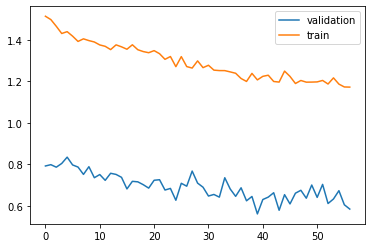

In [ ]:
history.history.keys()
plt.plot(history.history.get('val_loss'), label="validation")
plt.plot(history.history.get('loss'), label="train")
plt.legend()

In [ ]:
y_pred_score = model.predict(X_val)
y_pred = np.zeros(len(y_pred_score))
for i in range(len(y_pred_score)):
    if(y_pred_score[i,0] > 0.5 ):
        y_pred[i] = 1

In [ ]:
model.evaluate(X_val, t_val)

20/20 [==============================] - 0s 1ms/step - loss: 0.5609 - accuracy: 0.6922


[0.5609360933303833, 0.6921824216842651]

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(t_val, y_pred)

array([[404, 178],
       [ 11,  21]])

In [ ]:
print(accuracy_score(t_val, y_pred))
print(recall_score(t_val, y_pred))
print(roc_auc_score(t_val, y_pred))

0.6921824104234527
0.65625
0.6752040378006873


In [ ]:
#No correr
confusion_matrix(df.stroke, y_pred)#no olvidar que use una red con dos capas dense una de 300 y otra de 100 y pesos 0:1 1:100
#[1657, 2227],
#[   9,  195]

array([[2645, 1239],
       [  48,  156]])